In [0]:
%matplotlib inline

In [0]:
import pandas as pd
dataset=pd.read_excel('/content/BD.xlsx')

In [0]:
#Se pone la fecha como nombre de fila
dataset.index = dataset['Fecha']
del dataset['Fecha']
#Se elimina la P2: Precipitación de comparación ya que presenta el mismo comportamiento que P1
del dataset['P2']

dataset.head()

,Niv_Altavista,Humedad,P1,Pres,Temp,Vel_Viento,Dir_Viento
Fecha,,,,,,,
17/11/2017 12:00,25.757833,62.066122,0.0000,820.846737,22.549184,2.572449,231.551020
17/11/2017 13:00,27.331833,71.400500,0.0000,820.136160,21.335667,2.153833,240.733333
17/11/2017 14:00,29.239815,70.775667,0.0000,819.037501,21.774667,1.715667,254.283333
17/11/2017 15:00,28.260238,81.291333,0.0254,818.563001,20.211833,1.860000,241.583333
17/11/2017 16:00,28.776250,93.666167,0.0889,818.652501,17.678000,1.957167,231.450000


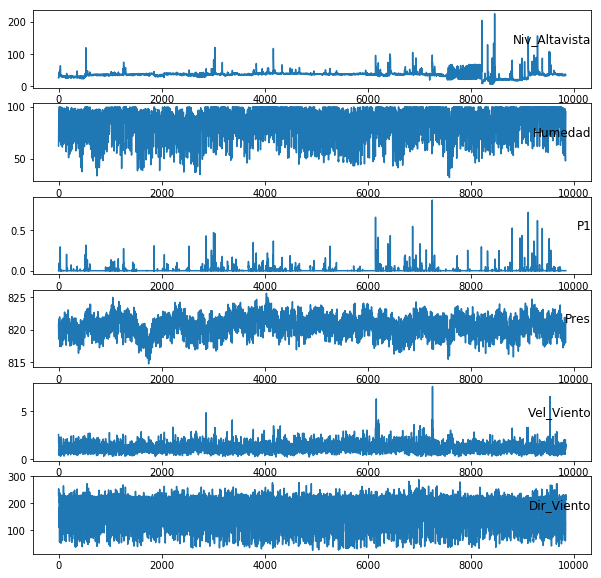

In [0]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
#dataset = read_csv('/content/pollution.csv', compression='gzip', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6]
i = 1
# plot each column
pyplot.figure(figsize=(10,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [0]:
print dataset.columns[0]
print values.shape

Niv_Altavista
(9847, 7)


In [0]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
def create_dataset_multiserie(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1):
	dataX, dataY = [], []
	tem = n_steps_in + n_steps_out - overlap
	for i in range(int((dataset.shape[0] - tem)/overlap)):
		startx = i*overlap
		endx = startx + n_steps_in
		starty = endx
		endy = endx + n_steps_out
		a = dataset[startx:endx, :]
		dataX.append(a)
		dataY.append(dataset[starty:endy, :])
	return np.array(dataX), np.array(dataY)

In [0]:
from sklearn import preprocessing
from DataPreparationRNN import split_sequence
from sklearn.preprocessing import MinMaxScaler
# Transformar datos de viento en números
#encoder = preprocessing.LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
#values = values.astype('float32')

In [0]:
train_size = int(values.shape[0] * 0.67)
test_size = values.shape[0] - train_size
train, test = values[0:train_size,:], values[train_size:values.shape[0],:]
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)

In [0]:
look_back = 1
time_ahead = 1
X_train,Y_train=create_dataset_multiserie(trainN,time_ahead,look_back,overlap=1)
X_test,Y_test=create_dataset_multiserie(testN,time_ahead,look_back,overlap=1)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

((6596, 1, 7), (6596, 1, 7), (3249, 1, 7), (3249, 1, 7))


## Exercise 2

Create thre models one based on conventional RNNs, one based on LSTM and a last one based on GRU units. Compare the performance of the models predicting one step forward. For all the models use one recurrent layer with 50 neurons.

In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from sklearn.metrics import mean_squared_error
from DataPreparationRNN import EstimaRMSE
from DataPreparationRNN import EstimaRMSE_RNN
from DataPreparationRNN import EstimaRMSE_MultiOuput
from DataPreparationRNN import EstimaRMSE_RNN_MultiStep
from DataPreparationRNN import EstimaRMSE_MultiStep
from DataPreparationRNN import EstimaRMSE_RNN_MultiStepEncoDeco
from DataPreparationRNN import PintaResultado
from DataPreparationRNN import create_dataset
from sklearn.metrics import mean_squared_error
from DataPreparationRNN import create_datasetMultipleTimesBackAhead

Using TensorFlow backend.


In [0]:
#RNN
Pollu_RNN=[]
No_pollu_RNN=[]
model_RNN=[]
model_RNN_no=[]
for i in range(1,11):
    X_train,Y_train=create_dataset_multiserie(trainN,1,i,overlap=1)
    X_test,Y_test=create_dataset_multiserie(testN,1,i,overlap=1)
    model = Sequential()
    model.add(SimpleRNN(50,activation = 'relu',input_shape=(i,trainN.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')
    model.fit(X_train, Y_train[:,:,0].flatten(),epochs=5, verbose=1)      
    predicts=model.predict(X_test)
    mse=mean_squared_error(predicts,Y_test[:,:,0])
    Pollu_RNN.append(mse)
    model_RNN.append(model)
for i in range(1,11):
    X_train,Y_train=create_dataset_multiserie(trainN,1,i,overlap=1)
    X_test,Y_test=create_dataset_multiserie(testN,1,i,overlap=1)
    model1 = Sequential()
    model1.add(SimpleRNN(50,activation = 'relu',input_shape=(i,trainN.shape[1]-1)))
    model1.add(Dense(1))
    model1.compile(optimizer='adam',loss='mse')
    model1.fit(X_train[:,:,1:], Y_train[:,:,0].flatten(),epochs=5, verbose=1)      
    predicts=model1.predict(X_test[:,:,1:])
    mse=mean_squared_error(predicts,Y_test[:,:,0])
    No_pollu_RNN.append(mse)
    model_RNN_no.append(model1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
6596/6596 [==============================] - 3s 486us/step - loss: 0.0012
Epoch 2/5
6596/6596 [==============================] - 1s 97us/step - loss: 6.5084e-04
Epoch 3/5
6596/6596 [==============================] - 1s 96us/step - loss: 6.2145e-04
Epoch 4/5
6596/6596 [==============================] - 1s 97us/step - loss: 5.8783e-04
Epoch 5/5
6596/6596 [==============================] - 1s 94us/step - loss: 5.6153e-04
Epoch 1/5
6595/6595 [==============================] - 1s 139us/step - loss: 0.0027
Epoch 2/5
6595/6595 [==============================] - 1s 112us/step - loss: 8.5013e-04
Epoch 3/5
6595/6595 [==============================] - 1s 111us/step - loss: 6.7467e-04
Epoch 4/5
6595/6595 [==============================] - 1s 114us/step - loss: 5.8440e-04
Epoch 5/5
6595/6595 [==============================] - 1s 110us/step - loss: 5.8422e-04
Epoch 1/5
65

In [0]:
#LSTM
Pollu_LSTM=[]
No_pollu_LSTM=[]
model_LSTM=[]
model_LSTM_no=[]
for i in range(1,11):
    X_train,Y_train=create_dataset_multiserie(trainN,1,i,overlap=1)
    X_test,Y_test=create_dataset_multiserie(testN,1,i,overlap=1)
    model2 = Sequential()
    model2.add(LSTM(50,input_shape=(i,trainN.shape[1])))
    model2.add(Dense(1))
    model2.compile(optimizer='adam',loss='mse')
    model2.fit(X_train, Y_train[:,:,0].flatten(),epochs=5, verbose=1)      
    predicts=model2.predict(X_test)
    mse=mean_squared_error(predicts,Y_test[:,:,0])
    Pollu_LSTM.append(mse)
    model_LSTM.append(model2)
for i in range(1,11):
    X_train,Y_train=create_dataset_multiserie(trainN,1,i,overlap=1)
    X_test,Y_test=create_dataset_multiserie(testN,1,i,overlap=1)
    model3 = Sequential()
    model3.add(LSTM(50,input_shape=(i,trainN.shape[1]-1)))
    model3.add(Dense(1))
    model3.compile(optimizer='adam',loss='mse')
    model3.fit(X_train[:,:,1:], Y_train[:,:,0].flatten(),epochs=5, verbose=1)      
    predicts=model3.predict(X_test[:,:,1:])
    mse=mean_squared_error(predicts,Y_test[:,:,0])
    No_pollu_LSTM.append(mse)
    model_LSTM_no.append(model3)

Epoch 1/5
6596/6596 [==============================] - 2s 366us/step - loss: 0.0025
Epoch 2/5
6596/6596 [==============================] - 1s 157us/step - loss: 0.0011
Epoch 3/5
6596/6596 [==============================] - 1s 157us/step - loss: 6.9701e-04
Epoch 4/5
6596/6596 [==============================] - 1s 157us/step - loss: 6.4535e-04
Epoch 5/5
6596/6596 [==============================] - 1s 157us/step - loss: 6.2143e-04
Epoch 1/5
6595/6595 [==============================] - 3s 425us/step - loss: 0.0024
Epoch 2/5
6595/6595 [==============================] - 1s 198us/step - loss: 0.0010
Epoch 3/5
6595/6595 [==============================] - 1s 197us/step - loss: 8.3313e-04
Epoch 4/5
6595/6595 [==============================] - 1s 198us/step - loss: 7.3113e-04
Epoch 5/5
6595/6595 [==============================] - 1s 200us/step - loss: 6.5190e-04
Epoch 1/5
6594/6594 [==============================] - 3s 495us/step - loss: 0.0026
Epoch 2/5
6594/6594 [==============================]

In [0]:
#GRU
Pollu_GRU=[]
No_pollu_GRU=[]
model_GRU=[]
model_GRU_no=[]
for i in range(1,11):
    X_train,Y_train=create_dataset_multiserie(trainN,1,i,overlap=1)
    X_test,Y_test=create_dataset_multiserie(testN,1,i,overlap=1)
    model4 = Sequential()
    model4.add(GRU(50,input_shape=(i,trainN.shape[1])))
    model4.add(Dense(units=1))
    model4.compile(optimizer='adam',loss='mse')
    model4.fit(X_train, Y_train[:,:,0].flatten(),epochs=5, verbose=1)      
    predicts=model4.predict(X_test)
    mse=mean_squared_error(predicts,Y_test[:,:,0])
    Pollu_GRU.append(mse)
    model_GRU.append(model4)
for i in range(1,11):
    X_train,Y_train=create_dataset_multiserie(trainN,1,i,overlap=1)
    X_test,Y_test=create_dataset_multiserie(testN,1,i,overlap=1)
    model5 = Sequential()
    model5.add(GRU(50,input_shape=(i,trainN.shape[1]-1)))
    model5.add(Dense(units=1))
    model5.compile(optimizer='adam',loss='mse')
    model5.fit(X_train[:,:,1:], Y_train[:,:,0].flatten(),epochs=5, verbose=1)      
    predicts=model5.predict(X_test[:,:,1:])
    mse=mean_squared_error(predicts,Y_test[:,:,0])
    No_pollu_GRU.append(mse)
    model_GRU_no.append(model5)

Epoch 1/5
6596/6596 [==============================] - 5s 796us/step - loss: 0.0020
Epoch 2/5
6596/6596 [==============================] - 1s 147us/step - loss: 7.8477e-04
Epoch 3/5
6596/6596 [==============================] - 1s 148us/step - loss: 6.4290e-04
Epoch 4/5
6596/6596 [==============================] - 1s 148us/step - loss: 6.2775e-04
Epoch 5/5
6596/6596 [==============================] - 1s 149us/step - loss: 6.2524e-04
Epoch 1/5
6595/6595 [==============================] - 6s 845us/step - loss: 0.0028
Epoch 2/5
6595/6595 [==============================] - 1s 179us/step - loss: 8.4129e-04
Epoch 3/5
6595/6595 [==============================] - 1s 176us/step - loss: 7.2394e-04
Epoch 4/5
6595/6595 [==============================] - 1s 178us/step - loss: 6.6834e-04
Epoch 5/5
6595/6595 [==============================] - 1s 176us/step - loss: 6.2124e-04
Epoch 1/5
6594/6594 [==============================] - 6s 899us/step - loss: 0.0022
Epoch 2/5
6594/6594 [=======================

Text(0,0.5,'MSE')

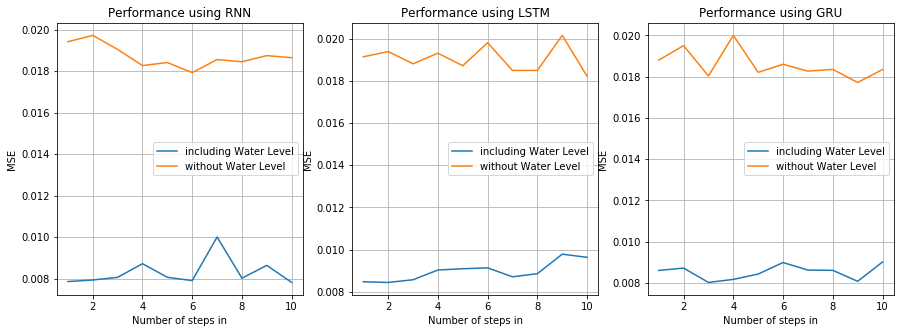

In [0]:
x=range(1,11)
pyplot.figure(figsize=(15,5))
pyplot.subplot(1,3,1)
pyplot.plot(x,Pollu_RNN,label="including Water Level")
pyplot.plot(x,No_pollu_RNN,label="without Water Level")
pyplot.legend()
pyplot.grid()
pyplot.title('Performance using RNN')
pyplot.xlabel('Number of steps in')
pyplot.ylabel('MSE')
pyplot.subplot(1,3,2)
pyplot.plot(x,Pollu_LSTM,label="including Water Level")
pyplot.plot(x,No_pollu_LSTM,label="without Water Level")
pyplot.legend()
pyplot.grid()
pyplot.title('Performance using LSTM')
pyplot.xlabel('Number of steps in')
pyplot.ylabel('MSE')
pyplot.subplot(1,3,3)
pyplot.plot(x,Pollu_GRU,label="including Water Level")
pyplot.plot(x,No_pollu_GRU,label="without Water Level")
pyplot.legend()
pyplot.grid()
pyplot.title('Performance using GRU')
pyplot.xlabel('Number of steps in')
pyplot.ylabel('MSE')

In [0]:
X_train,Y_train=create_dataset_multiserie(trainN,time_ahead,9,overlap=1) #9 pasos hacia atrás
X_test,Y_test=create_dataset_multiserie(testN,time_ahead,9,overlap=1)
Predict_pollu_train = model_LSTM[8].predict(X_train) #Pollution
Predict_pollu_test = model_LSTM[8].predict(X_test)
trainPredict_no_pol = model_LSTM_no[8].predict(X_train[:,:,1:])
testPredict_no_pol = model_LSTM_no[8].predict(X_test[:,:,1:])

In [0]:
data_org = scaler.fit_transform(values[:,0].reshape(-1, 1))
train_size
x1=np.arange(0,train_size-9)
x2=np.arange(train_size,len(data_org[:,0])-9)
x1.shape,Predict_pollu_train.shape

((6588,), (6588, 1))

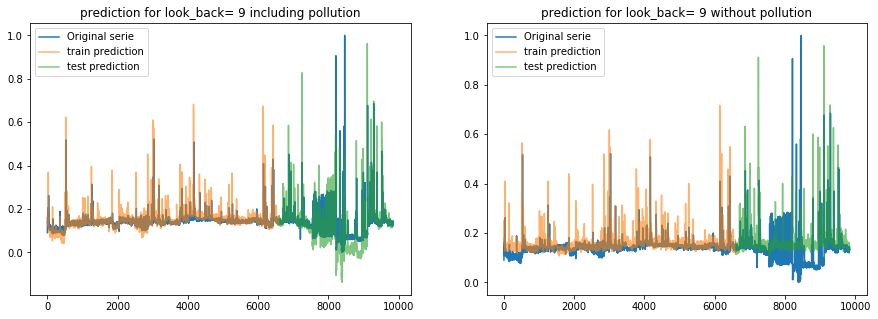

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(data_org, alpha=1, label='Original serie');
plt.plot(x1,Predict_pollu_train,alpha=0.6, label='train prediction');
plt.plot(x2,Predict_pollu_test, alpha=0.6, label='test prediction');
plt.title("prediction for look_back= 9 including pollution")
plt.legend();
plt.subplot(1,2,2)
plt.plot(data_org, alpha=1, label='Original serie');
plt.plot(x1,trainPredict_no_pol,alpha=0.6, label='train prediction');
plt.plot(x2,testPredict_no_pol, alpha=0.6, label='test prediction');
plt.title("prediction for look_back= 9 without pollution")
plt.legend();